ANALISIS DE RESULTADOS 

In [3]:
!pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 25.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 40.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m7/8 [seaborn]ib]


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("resultados_text_analytics.xlsx")

df.head()


,Archivo,Idioma,Sentimiento,Key_Phrases,Entities,Links
0,review30.txt,Spanish,negative,"tres semanas, error interno, solicitud, altern...","tres semanas (DateTime), solicitud (Skill)",NaN
1,review29.txt,Spanish,negative,"préstamo, trato, personal, Sentí, dudas",personal (PersonType),El Préstamo (https://en.wikipedia.org/wiki/El_...
2,review16.txt,Spanish,mixed,"préstamo, una semana, observaciones, documento...","una semana (DateTime), asesores (PersonType), ...",El Préstamo (https://en.wikipedia.org/wiki/El_...
3,review1.txt,Spanish,positive,"Caja Municipal ADV, dos días, préstamo, dinero...","Caja Municipal ADV (Organization), dos días (D...",Spondias mombin (https://en.wikipedia.org/wiki...
4,review6.txt,Spanish,positive,"cinco días, tres pasos simples, préstamo, eval...","cinco días (DateTime), solicitud (Skill), eval...",El (deity) (https://en.wikipedia.org/wiki/El_(...


REVISION RESUMEN SENTIMIENTOS

Sentimiento
positive    13
negative    11
mixed        6
Name: count, dtype: int64


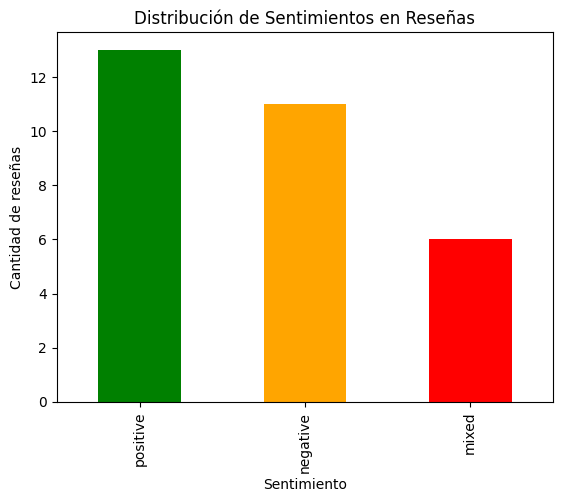

In [5]:

conteo_sentimientos = df['Sentimiento'].value_counts()

print(conteo_sentimientos)

conteo_sentimientos.plot(kind='bar', color=['green', 'orange', 'red', 'gray'])
plt.title("Distribución de Sentimientos en Reseñas")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de reseñas")
plt.show()


PALABRAS CLAVES MAS FRECUENTES

In [6]:
from collections import Counter
import itertools


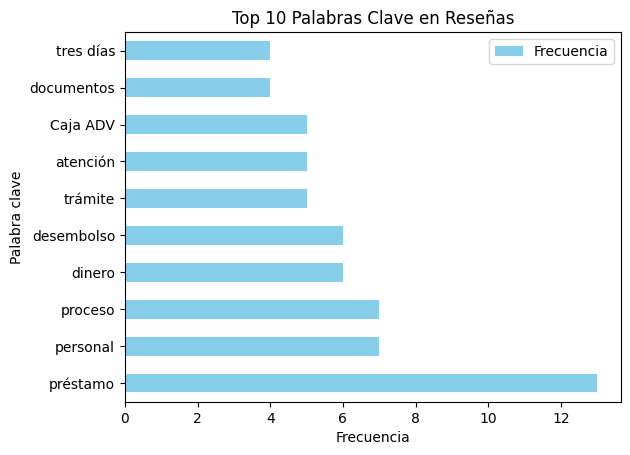

In [7]:
todas = list(itertools.chain.from_iterable([str(k).split(', ') for k in df['Key_Phrases']]))

palabras_frecuentes = Counter(todas).most_common(10)

df_palabras = pd.DataFrame(palabras_frecuentes, columns=['Palabra', 'Frecuencia'])

df_palabras.plot(kind='barh', x='Palabra', y='Frecuencia', color='skyblue')
plt.title("Top 10 Palabras Clave en Reseñas")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra clave")
plt.show()


PALABRAS CLAVE POR SENTIMIENTO (positivos vs ngeativos)

In [10]:
from collections import Counter
import itertools
import pandas as pd

In [9]:
def top_phrases_por_sentimiento(df, senti='negative', k=15):
    frases = (
        df.loc[df['Sentimiento'].str.lower()==senti, 'Key_Phrases']
          .dropna()
          .map(lambda x: [p.strip() for p in str(x).split(',') if p.strip()])
    )
    todas = list(itertools.chain.from_iterable(frases))
    return pd.DataFrame(Counter(todas).most_common(k), columns=['frase','freq'])

top_neg = top_phrases_por_sentimiento(df, 'negative', 15)
top_pos = top_phrases_por_sentimiento(df, 'positive', 15)

display(top_neg.head(15))
display(top_pos.head(15))


,frase,freq
0,préstamo,3
1,dinero,3
2,personal,2
3,trámite,2
4,evaluación,2
5,desembolso,2
6,atención,2
7,dos semanas,2
8,documentos,2
9,tres semanas,1


,frase,freq
0,préstamo,7
1,proceso,4
2,Caja ADV,4
3,dos días,3
4,dinero,3
5,personal,3
6,tres días,3
7,solicitud,2
8,asesora,2
9,desembolso,2


LIMPIEZA Y PREPARAION DE HELPERS

In [14]:
import re, unicodedata
from collections import Counter, defaultdict
import numpy as np

def norm(s):
    s = str(s or "")
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode()
    return s.lower().strip()

df["Sentimiento"] = df["Sentimiento"].str.lower()
df["Key_Phrases_norm"] = df["Key_Phrases"].fillna("").apply(norm)
df["Entities_norm"]     = df["Entities"].fillna("").apply(norm)


Co-ocurrencias de frases clave por sentimiento (heatmap TOP términos vs sentimiento)

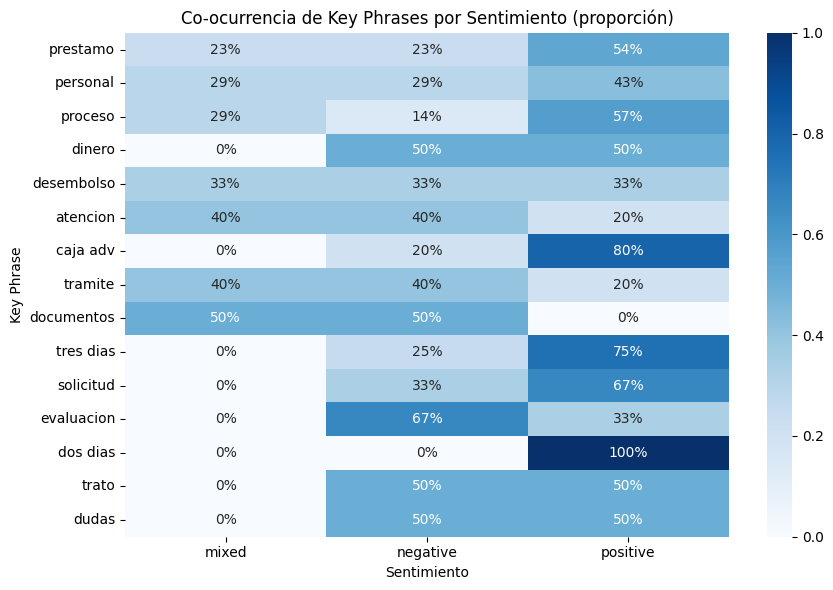

In [15]:

rows = []
for _, r in df.iterrows():
    for kp in [k for k in r["Key_Phrases_norm"].split(", ") if k]:
        rows.append((kp, r["Sentimiento"]))
cooc = pd.DataFrame(rows, columns=["kp","sent"])

top_kp = cooc["kp"].value_counts().head(15).index
subset = cooc[cooc["kp"].isin(top_kp)]

pivot = pd.crosstab(subset["kp"], subset["sent"]).reindex(index=top_kp)
pivot = pivot.div(pivot.sum(axis=1), axis=0)  # proporciones por frase

plt.figure(figsize=(9,6))
sns.heatmap(pivot, annot=True, fmt=".0%", cmap="Blues")
plt.title("Co-ocurrencia de Key Phrases por Sentimiento (proporción)")
plt.xlabel("Sentimiento")
plt.ylabel("Key Phrase")
plt.tight_layout()
plt.show()


Extracción de tiempos de proceso (días/horas) desde entidades y relación con sentimiento

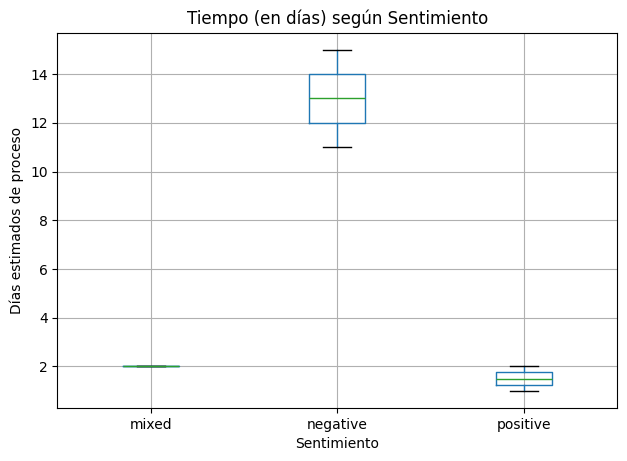

Promedios por sentimiento (días):
Sentimiento
mixed        2.0
negative    13.0
positive     1.5
Name: tiempo_dias, dtype: float64


In [16]:
def parse_tiempo(s):
    s = s or ""
    dias   = [int(x) for x in re.findall(r"(\d+)\s*d[ií]as?", s)]
    horas  = [int(x) for x in re.findall(r"(\d+)\s*horas?", s)]
    sem    = [int(x) for x in re.findall(r"(\d+)\s*seman", s)]
    vals_dias  = dias
    vals_dias += [h/24 for h in horas]
    vals_dias += [w*7 for w in sem]
    return np.median(vals_dias) if vals_dias else np.nan

df["tiempo_dias"] = df["Entities_norm"].apply(parse_tiempo)

ax = df.boxplot(column="tiempo_dias", by="Sentimiento", figsize=(7,5))
plt.title("Tiempo (en días) según Sentimiento")
plt.suptitle("")
plt.xlabel("Sentimiento")
plt.ylabel("Días estimados de proceso")
plt.show()

print("Promedios por sentimiento (días):")
print(df.groupby("Sentimiento")["tiempo_dias"].mean().round(2))


Temas de negocio (rapidez, trato, requisitos, comunicación, errores) con uplift negativo/positivo

<Figure size 900x600 with 0 Axes>

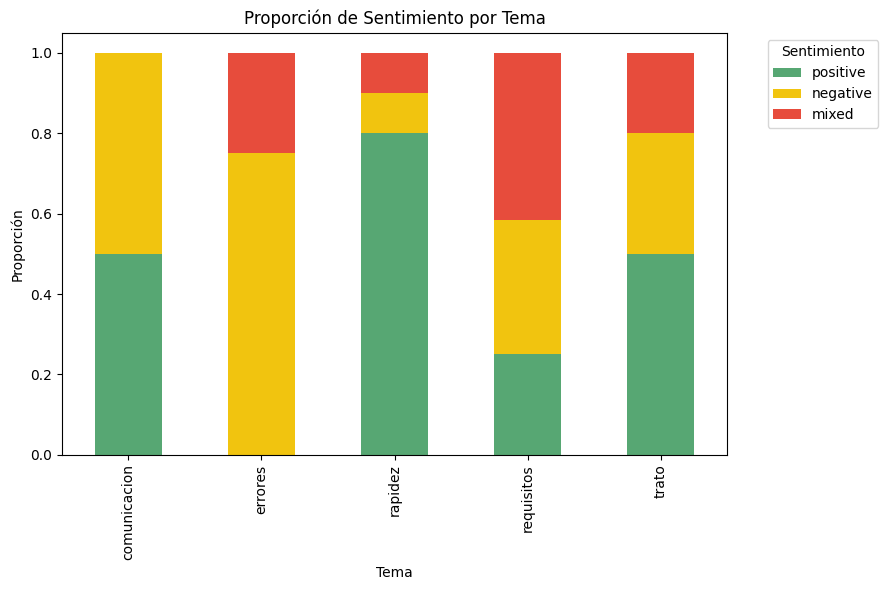

Uplift de sentimiento negativo por tema (↑ = peor que el promedio):


temas
errores         0.38
comunicacion    0.13
requisitos     -0.03
trato          -0.07
rapidez        -0.27
Name: neg_rate, dtype: float64


📉 El tema con mayor impacto negativo es 'errores', con un uplift de 38.3% sobre el promedio de negatividad global.


In [ ]:
temas = {
    "rapidez":      ["rapido", "48 horas", "24 horas", "dos dias", "tres dias", "agil"],
    "requisitos":   ["documento", "requisito", "burocrat", "tramite", "firma", "formulari"],
    "comunicacion": ["comunicacion", "correo", "whatsapp", "informaron", "respuesta"],
    "trato":        ["trato", "amable", "empatico", "respeto", "atencion"],
    "errores":      ["error", "observacion", "coordinacion", "cancelaron"]
}

def tag_temas(texto):
    hits = set()
    for t, kws in temas.items():
        if any(k in texto for k in kws):
            hits.add(t)
    return list(hits)

df["temas"] = df["Key_Phrases_norm"].apply(tag_temas)

df_t = df.explode("temas").dropna(subset=["temas"])

dist = pd.crosstab(df_t["temas"], df_t["Sentimiento"])
dist_prop = dist.div(dist.sum(axis=1), axis=0)

cols = [c for c in ["positive","neutral","negative","mixed"] if c in dist_prop.columns]

plt.figure(figsize=(9,6))
dist_prop[cols].plot(kind="bar", stacked=True, figsize=(9,6), color=["#57A773","#F1C40F","#E74C3C","#95A5A6"])
plt.title("Proporción de Sentimiento por Tema")
plt.ylabel("Proporción")
plt.xlabel("Tema")
plt.legend(title="Sentimiento", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

neg_rate_tema = (dist["negative"] / dist.sum(axis=1)).rename("neg_rate")
neg_rate_global = (df["Sentimiento"]=="negative").mean()
uplift = (neg_rate_tema - neg_rate_global).sort_values(ascending=False)

print("Uplift de sentimiento negativo por tema (↑ = peor que el promedio):")
display(uplift.round(2))

tema_peor = uplift.idxmax()
impacto = (uplift.max()*100).round(1)
print(f"\n📉 El tema con mayor impacto negativo es '{tema_peor}', con un uplift de {impacto}% sobre el promedio de negatividad global.")


Top motivos de satisfacción e insatisfacción (palabras clave por sentimiento)

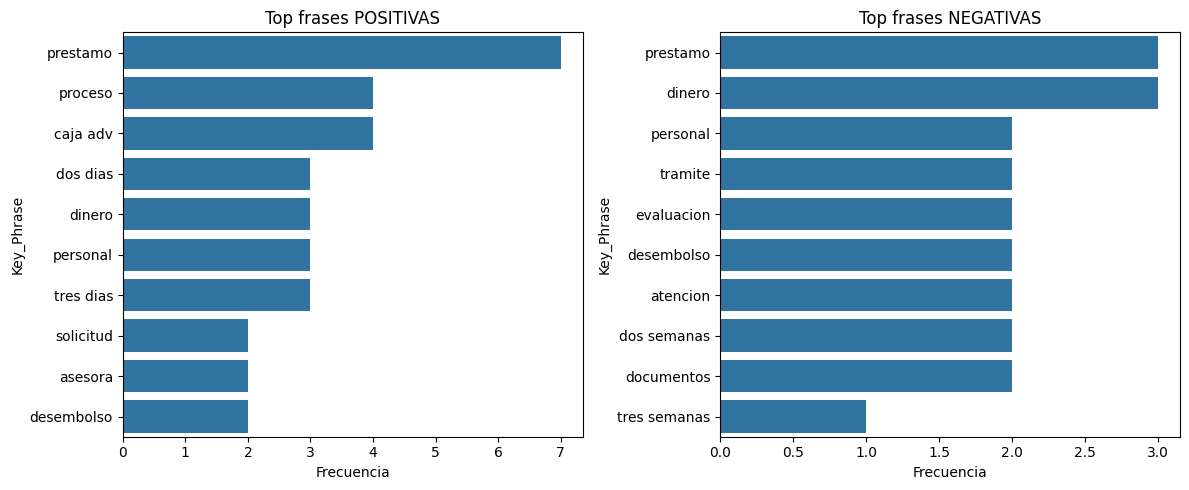

,Key_Phrase,Frecuencia
0,prestamo,7
1,proceso,4
2,caja adv,4
3,dos dias,3
4,dinero,3
5,personal,3
6,tres dias,3
7,solicitud,2
8,asesora,2
9,desembolso,2


,Key_Phrase,Frecuencia
0,prestamo,3
1,dinero,3
2,personal,2
3,tramite,2
4,evaluacion,2
5,desembolso,2
6,atencion,2
7,dos semanas,2
8,documentos,2
9,tres semanas,1


In [19]:
def top_kp_por_sent(sent, k=10):
    subset = df[df["Sentimiento"]==sent]["Key_Phrases_norm"].str.split(", ").dropna()
    todas = [w for lst in subset for w in lst if w]
    top = Counter(todas).most_common(k)
    return pd.DataFrame(top, columns=["Key_Phrase","Frecuencia"])

top_pos = top_kp_por_sent("positive", 10)
top_neg = top_kp_por_sent("negative", 10)

fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.barplot(y="Key_Phrase", x="Frecuencia", data=top_pos, ax=axes[0])
axes[0].set_title("Top frases POSITIVAS")
sns.barplot(y="Key_Phrase", x="Frecuencia", data=top_neg, ax=axes[1])
axes[1].set_title("Top frases NEGATIVAS")
plt.tight_layout(); plt.show()

display(top_pos); display(top_neg)


Entidades clave (Organizaciones, Ubicaciones, Tipos de persona) – radar rápido

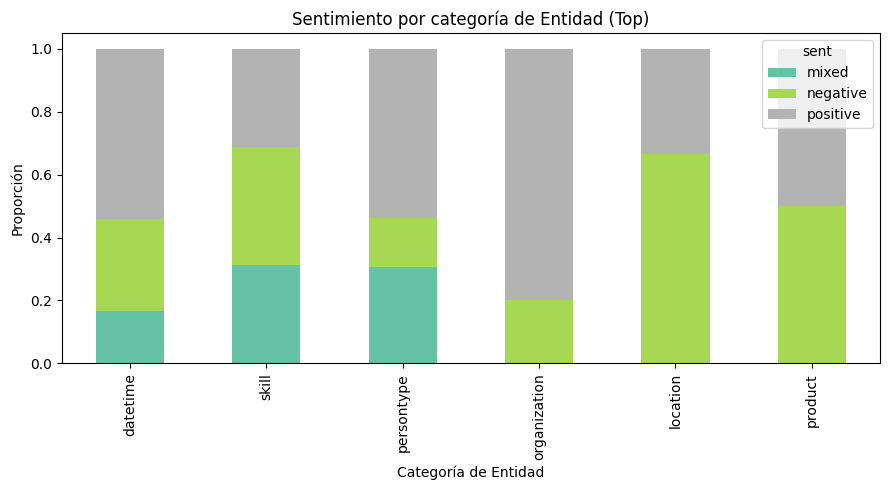

sent,mixed,negative,positive
categoria,,,
datetime,4,7,13
skill,5,6,5
persontype,4,2,7
organization,0,1,4
location,0,2,1
product,0,1,1


In [20]:

def split_entities(s):
    # formato: "texto (categoria), texto (categoria)"
    pairs = re.findall(r"([^,]+?)\s*\(([^)]+)\)", s or "")
    return pairs

rows = []
for _, r in df.iterrows():
    for text, cat in split_entities(r["Entities"]):
        rows.append((text.strip().lower(), cat.strip().lower(), r["Sentimiento"]))
ents = pd.DataFrame(rows, columns=["entidad","categoria","sent"])

cat_pivot = pd.crosstab(ents["categoria"], ents["sent"])
cat_pivot = cat_pivot.loc[cat_pivot.sum(axis=1).sort_values(ascending=False).head(6).index]

cat_prop = cat_pivot.div(cat_pivot.sum(axis=1), axis=0)
cat_prop.plot(kind="bar", stacked=True, figsize=(9,5), cmap="Set2")
plt.title("Sentimiento por categoría de Entidad (Top)")
plt.ylabel("Proporción")
plt.xlabel("Categoría de Entidad")
plt.tight_layout()
plt.show()

display(cat_pivot)


Resumen ejecutivo exportable (KPIs y tabla final)

In [21]:
kpis = {
    "total_resenas": len(df),
    "pct_positivo": (df["Sentimiento"]=="positive").mean(),
    "pct_negativo": (df["Sentimiento"]=="negative").mean(),
    "tiempo_medio_dias": float(np.nanmean(df["tiempo_dias"])) if "tiempo_dias" in df else np.nan
}
kpis_df = pd.DataFrame([kpis])
kpis_df["pct_positivo"] = (kpis_df["pct_positivo"]*100).round(1)
kpis_df["pct_negativo"] = (kpis_df["pct_negativo"]*100).round(1)

with pd.ExcelWriter("resumen_analitico_ADV.xlsx", engine="openpyxl") as xw:
    kpis_df.to_excel(xw, sheet_name="KPIs", index=False)
    (df[["Archivo","Sentimiento","Key_Phrases","Entities","Links","tiempo_dias"]]
     .to_excel(xw, sheet_name="Detalle", index=False))
    uplift.round(3).to_frame("uplift_neg").to_excel(xw, sheet_name="Temas_Uplift")

print("✅ Resumen exportado a resumen_analitico_ADV.xlsx")
kpis_df


✅ Resumen exportado a resumen_analitico_ADV.xlsx


,total_resenas,pct_positivo,pct_negativo,tiempo_medio_dias
0,30,43.3,36.7,6.2
